## Import All Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import Ridge
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
#import the dataset
dataset = pd.read_csv("MIT-BIH Arrhythmia Database.csv")

TODO:
- take representative sample of dataset (aim for 15,000 rows)
- perform preprocessing

## Understanding the Data

- "record" is the name of the subject/patient.
- "type" is the target, which contains 5 categories of heart beats:
    1. N (Normal)
    2. SVEB (Supraventricular ectopic beat)
    3. VEB (Ventricular ectopic beat)
    4. F (Fusion beat)
    5. Q (Unknown beat)


## Data Visualization

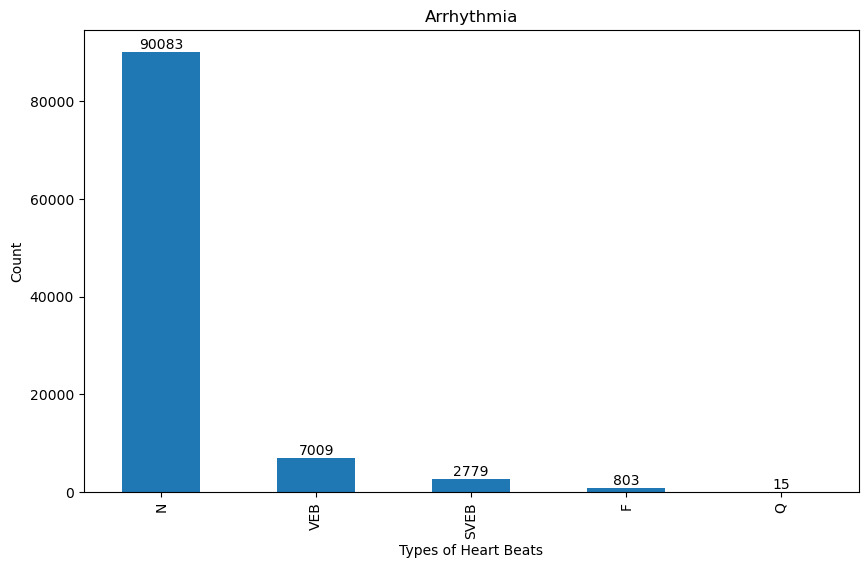

In [3]:
data = dataset['type'].value_counts()


# Create a bar plot
plt.figure(figsize=(10,6))
bars = data.plot(kind='bar')

# Set the title and labels
plt.title('Arrhythmia')
plt.xlabel('Types of Heart Beats')
plt.ylabel('Count')

for container in bars.containers:
    bars.bar_label(container)

# Show the plot
plt.show()

### Don't remove the comment below until final! It will take a lot of spaces

In [4]:
#data visualization (before data cleaning)
# features = dataset.drop('type', axis=1).columns
# target = dataset['type']

# fig, axs = plt.subplots(len(features), 1, figsize=(5, 5*len(features)))

# for i, feature in enumerate(features):
#     axs[i].scatter(dataset[feature], target)
#     axs[i].set_xlabel(feature)
#     axs[i].set_ylabel('Heartbeat')

# plt.tight_layout()
# plt.show()

## Data cleaning

In [5]:
#we drop "record" column from our dataset because it is not helpful as "record" is the name of the subject/patient.
dataset.drop('record', axis=1, inplace=True)

In [6]:
#check for the null or missing value in the dataset
dataset.isnull().sum()

type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

In [7]:
#check for the number of duplicates in the dataset
dataset.duplicated().sum()

0

#### We can encode it with Normal vs Other
#### If not, then the confusion matrix might not be good unless we do multiple comparisons like N vs VEB, N vs SVEB, VEB vs SVEB...

In [8]:
#encode categorical variables using label encoder (N = 1, VEB = 4, SVEB = 3, F = 0, Q = 2)
le = LabelEncoder()
dataset['type'] = le.fit_transform(dataset['type'])

### I did some testing, by removing outliers in the features (excluding "type"), we will be down to about 50k rows...

## Data Analysis

,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
type,1.000000,-0.335534,0.126652,0.286443,0.056004,-0.273982,-0.205667,-0.251187,0.110612,0.167335,...,-0.038247,0.076347,0.234544,0.260842,0.171123,-0.038247,-0.023762,-0.012596,-0.026128,-0.026198
0_pre-RR,-0.335534,1.000000,0.504007,-0.124099,0.018983,0.038273,0.105471,0.131640,-0.069550,-0.118889,...,0.014193,0.105931,-0.065458,-0.050930,-0.174025,0.014193,0.052227,0.125851,0.192611,0.176455
0_post-RR,0.126652,0.504007,1.000000,0.022403,0.053710,-0.058405,-0.004231,0.036518,0.007791,-0.020976,...,-0.014826,0.157338,0.067440,0.083962,-0.112480,-0.014826,0.036218,0.127102,0.198940,0.188837
0_pPeak,0.286443,-0.124099,0.022403,1.000000,0.034470,-0.169739,-0.125511,0.067251,0.070066,0.460317,...,-0.091219,-0.030443,0.201962,0.154688,0.140814,-0.091219,-0.091008,-0.093754,-0.108299,-0.088811
0_tPeak,0.056004,0.018983,0.053710,0.034470,1.000000,0.046260,0.783438,-0.025503,-0.351845,-0.072072,...,0.118974,0.055038,-0.030694,0.002113,-0.039031,0.118974,0.127477,0.130509,0.122410,0.116725
0_rPeak,-0.273982,0.038273,-0.058405,-0.169739,0.046260,1.000000,0.157976,0.385727,0.283718,-0.040067,...,-0.045745,-0.039467,-0.188200,-0.134191,-0.022609,-0.045745,-0.047524,-0.074171,-0.108523,-0.132983
0_sPeak,-0.205667,0.105471,-0.004231,-0.125511,0.783438,0.157976,1.000000,0.211764,-0.366937,-0.066051,...,0.244515,0.077266,-0.173273,-0.139437,-0.201204,0.244515,0.234033,0.213104,0.203169,0.195489
0_qPeak,-0.251187,0.131640,0.036518,0.067251,-0.025503,0.385727,0.211764,1.000000,0.065802,-0.162882,...,0.026328,0.040827,-0.047777,-0.004580,-0.016565,0.026328,0.036162,0.039800,0.035156,0.038308
0_qrs_interval,0.110612,-0.069550,0.007791,0.070066,-0.351845,0.283718,-0.366937,0.065802,1.000000,0.365435,...,-0.192017,-0.123317,0.073343,0.091036,0.265992,-0.192017,-0.210007,-0.233223,-0.242125,-0.241333
0_pq_interval,0.167335,-0.118889,-0.020976,0.460317,-0.072072,-0.040067,-0.066051,-0.162882,0.365435,1.000000,...,-0.048267,-0.037509,0.110562,0.078272,0.092368,-0.048267,-0.075010,-0.108503,-0.131327,-0.128994


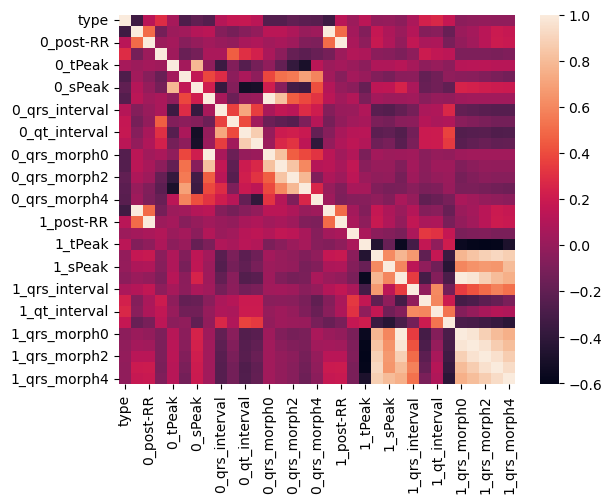

In [9]:
#check for correlations using heatmaps
correlation = dataset.corr()
sns.heatmap(correlation)
correlation